In [1]:

import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

2025-10-28 20:24:16.619745: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 20:24:17.635943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-28 20:24:18.098828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-28 20:24:18.102119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-28 20:24:18.833608: I tensorflow/core/platform/cpu_feature_gua

Running on Python Version: 3.9.21 (main, Feb 10 2025, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-5)]
Using Tensorflow Version: 2.16.2
Running on CPU


2025-10-28 20:24:30.159872: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: co1313-02.ece.iastate.edu
2025-10-28 20:24:30.159906: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: co1313-02.ece.iastate.edu
2025-10-28 20:24:30.160010: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-10-28 20:24:30.160048: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  580.95.05  Release Build  (root@co1313-02.ece.iastate.edu)  Sun Oct  5 13:38:12 CDT 2025
GCC version:  gcc version 11.5.0 20240719 (Red Hat 11.5.0-5) (GCC) 
"


In [2]:
# This cell imports our dataset.

# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/duweisu/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

In [3]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [4]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the class
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

def img_display(img, display=True, title=""):
    if display:
        plt.figure()
        plt.title(title)
        if img.shape.ndims > 3:
            plt.imshow(img.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(img.numpy())


In [5]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/<NETID>/path/to/your/lab1/CNN_TinyImageNet.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path)
model.summary()

/home/zfsalti/487/lab1/lab1_venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/zfsalti/487/lab1/lab1_venv/lib64/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,218 (2.94 MB)

 Trainable params: 770,216 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
QUANT_MAX = 127.0

In [ ]:


# input_avg = 0.0

# count = 0
# for val_img in ds_val:
#     if count > 8192:
#         break
#     count += 1
#     img_tensor = tf.cast(tf.reshape(val_img["image"], [1, 64, 64, 3]), tf.float32) / 255.0
#     avg = np.mean(img_tensor)
#     input_avg += avg

# input_avg /= count

# largest_mag = 0.0
# count = 0
# for val_img in ds_val:
#     if count > 8192:
#         break
#     count += 1
#     img_tensor = tf.cast(tf.reshape(val_img["image"], [1, 64, 64, 3]), tf.float32) / 255.0
#     avg_subbed = img_tensor - input_avg
#     biggest_mag = np.abs(avg_subbed).max()
#     if biggest_mag > largest_mag:
#         largest_mag = biggest_mag

# S_i = QUANT_MAX/largest_mag
# Z_i = -1.0 * S_i * input_avg
# print(f"S_i: {S_i} Z_i: {Z_i}")


# weights = model.layers[0].get_weights()[0]
# S_w = QUANT_MAX/np.abs(weights).max()
# S_b = S_i * S_w

# Zp_macced = []

# transpose : (Height, Width, Depth, nFilter) -> (nFilter, height, width, depth)
# (Height, Width, Depth, nFilter) -> (nFilter, height, width, depth)
# transpose of (3, 0, 1, 2)
# transposed_weights = np.transpose(weights, (3, 0, 1, 2))

# for filter in transposed_weights:
#     scaled = filter * Z_i
#     Zp_macced.append(scaled.sum())


# 


count = 0
PARAMED_LAYERS = 8
input_avgs = np.zeros(PARAMED_LAYERS)
min_acts = np.ones(PARAMED_LAYERS, dtype=float)
max_acts = np.ones(PARAMED_LAYERS, dtype=float)
for val_img in ds_val:
    if count > 5000:
        break
    count += 1
    img_tensor = tf.cast(tf.reshape(val_img["image"], [1, 64, 64, 3]), tf.float32) / 255.0
    inp_min = np.min(img_tensor)
    inp_max = np.max(img_tensor)
    if inp_min < min_acts[0]:
        min_acts[0] = inp_min
    if inp_max > max_acts[0]:
        max_acts[0] = inp_max
    input_avgs[0] += np.mean(img_tensor)


    clipped_model = Model(model.layers[0].input, model.layers[0].output)
    out = clipped_model.predict(img_tensor)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[1]:
        min_acts[1] = inp_min
    if inp_max > max_acts[1]:
        max_acts[1] = inp_max
    input_avgs[1] += np.mean(out)

    clipped_model = Model(model.layers[1].input, model.layers[1].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[2].input, model.layers[2].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[2]:
        min_acts[2] = inp_min
    if inp_max > max_acts[2]:
        max_acts[2] = inp_max
    input_avgs[2] += np.mean(out)

    clipped_model = Model(model.layers[3].input, model.layers[3].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[3]:
        min_acts[3] = inp_min
    if inp_max > max_acts[3]:
        max_acts[3] = inp_max
    input_avgs[3] += np.mean(out)

    clipped_model = Model(model.layers[4].input, model.layers[4].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[5].input, model.layers[5].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[4]:
        min_acts[4] = inp_min
    if inp_max > max_acts[4]:
        max_acts[4] = inp_max
    input_avgs[4] += np.mean(out)

    clipped_model = Model(model.layers[6].input, model.layers[6].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[5]:
        min_acts[5] = inp_min
    if inp_max > max_acts[5]:
        max_acts[5] = inp_max
    input_avgs[5] += np.mean(out)

    clipped_model = Model(model.layers[7].input, model.layers[7].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[8].input, model.layers[8].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[9].input, model.layers[9].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[6]:
        min_acts[6] = inp_min
    if inp_max > max_acts[6]:
        max_acts[6] = inp_max
    input_avgs[6] += np.mean(out)

    clipped_model = Model(model.layers[10].input, model.layers[10].output)
    out = clipped_model.predict(out)
    inp_min = np.min(out)
    inp_max = np.max(out)
    if inp_min < min_acts[7]:
        min_acts[7] = inp_min
    if inp_max > max_acts[7]:
        max_acts[7] = inp_max
    input_avgs[7] += np.mean(out)


input_avgs /= count
print(input_avgs)
print(min_acts)
print(max_acts)


largest_mags = np.zeros(PARAMED_LAYERS)
count = 0
for val_img in ds_val:
    if count > 5000:
        break
    count += 1

    img_tensor = tf.cast(tf.reshape(val_img["image"], [1, 64, 64, 3]), tf.float32) / 255.0
    avg_subbed = img_tensor - input_avgs[0]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[0]:
        largest_mags[0] = biggest_mag


    clipped_model = Model(model.layers[0].input, model.layers[0].output)
    out = clipped_model.predict(img_tensor)
    avg_subbed = out - input_avgs[1]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[1]:
        largest_mags[1] = biggest_mag

    clipped_model = Model(model.layers[1].input, model.layers[1].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[2].input, model.layers[2].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[2]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[2]:
        largest_mags[2] = biggest_mag

    clipped_model = Model(model.layers[3].input, model.layers[3].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[3]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[3]:
        largest_mags[3] = biggest_mag

    clipped_model = Model(model.layers[4].input, model.layers[4].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[5].input, model.layers[5].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[4]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[4]:
        largest_mags[4] = biggest_mag

    clipped_model = Model(model.layers[6].input, model.layers[6].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[5]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[5]:
        largest_mags[5] = biggest_mag

    clipped_model = Model(model.layers[7].input, model.layers[7].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[8].input, model.layers[8].output)
    out = clipped_model.predict(out)

    clipped_model = Model(model.layers[9].input, model.layers[9].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[6]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[6]:
        largest_mags[6] = biggest_mag

    clipped_model = Model(model.layers[10].input, model.layers[10].output)
    out = clipped_model.predict(out)
    avg_subbed = out - input_avgs[7]
    biggest_mag = np.abs(avg_subbed).max()
    if biggest_mag > largest_mags[7]:
        largest_mags[7] = biggest_mag

print(input_avgs)
print(min_acts)
print(max_acts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

2025-10-28 20:44:36.337431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

In [21]:


S_8b_is = 127.0 / largest_mags
S_4b_is = 7.0 / largest_mags
S_2b_is = 1.0 / largest_mags

print(S_8b_is)
print(S_4b_is)
print(S_2b_is)

Z_8b_is = -1.0 * S_8b_is * input_avgs
Z_4b_is = -1.0 * S_4b_is * input_avgs
Z_2b_is = -1.0 * S_2b_is * input_avgs

print(Z_8b_is)
print(Z_4b_is)
print(Z_2b_is)

[225.77330403  78.2820355   30.10063831  38.9806973   34.65046495
  22.17446924  14.83324517   8.22409603]
[12.44419786  4.31475786  1.6590903   2.14854237  1.90986815  1.22221484
  0.81758044  0.45329663]
[1.77774255 0.61639398 0.2370129  0.30693462 0.27283831 0.17460212
 0.11679721 0.06475666]
[-98.77330566  -2.59492527  -1.56697189  -1.29760205  -2.29752769
  -2.85158814  -2.35767725  -4.66986653]
[-5.44419795 -0.14302738 -0.08636853 -0.07152137 -0.12663538 -0.15717415
 -0.12995071 -0.25739422]
[-0.77774256 -0.02043248 -0.01233836 -0.01021734 -0.01809077 -0.02245345
 -0.01856439 -0.0367706 ]


In [14]:
# Lets not have to rerun the above

PARAMED_LAYERS = 8

S_8b_is = np.array([225.77330403, 78.2820355, 30.10063831, 38.9806973, 34.65046495, 22.17446924, 14.83324517, 8.22409603])

S_4b_is = np.array([12.44419786, 4.31475786, 1.6590903, 2.14854237, 1.90986815, 1.22221484, 0.81758044, 0.45329663])

S_2b_is = np.array([1.77774255, 0.61639398, 0.2370129,  0.30693462, 0.27283831, 0.17460212, 0.11679721, 0.06475666])

Z_8b_is = np.array([-98.77330566, -2.59492527, -1.56697189, -1.29760205, -2.29752769, -2.85158814, -2.35767725, -4.66986653])

Z_4b_is = np.array([-5.44419795, -0.14302738, -0.08636853, -0.07152137, -0.12663538, -0.15717415, -0.12995071, -0.25739422])

Z_2b_is = np.array([-0.77774256, -0.02043248, -0.01233836, -0.01021734, -0.01809077, -0.02245345, -0.01856439, -0.0367706])

In [15]:

max_mag_weights = []

for layer in model.layers:
    if len(layer.get_weights()) == 0: # Skip non paramed layers
        continue

    weights = layer.get_weights()[0]
    max_mag = np.abs(weights).max()
    max_mag_weights.append(max_mag)

np_max_mag_weights = np.array(max_mag_weights)

S_8b_ws = 127.0 / np_max_mag_weights
S_4b_ws = 7.0 / np_max_mag_weights
S_2b_ws = 1.0 / np_max_mag_weights

S_8b_bs = S_8b_is * S_8b_ws
S_4b_bs = S_4b_is * S_4b_ws
S_2b_bs = S_2b_is * S_2b_ws


print(S_8b_ws)
print(S_4b_ws)
print(S_2b_ws)



[419.30887 260.8992  183.42577 234.51324 236.64046 248.70012 227.76791
  95.91284]
[23.111511  14.380271  10.110082  12.925927  13.043175  13.707881
 12.554137   5.2865343]
[3.3016446 2.0543244 1.4442974 1.846561  1.8633107 1.9582686 1.7934481
 0.7552192]


In [16]:
Zp_macced_8b = []
Zp_macced_4b = []
Zp_macced_2b = []

param_layer = 0
for layer in model.layers:
    if len(layer.get_weights()) == 0:
        continue

    weights = layer.get_weights()[0]

    scaled_weights_8b = weights * S_8b_ws[param_layer]
    scaled_weights_4b = weights * S_4b_ws[param_layer]
    scaled_weights_2b = weights * S_2b_ws[param_layer]

    transposed_weights_8b = None
    transposed_weights_4b = None
    transposed_weights_2b = None
    if len(weights.shape) > 2:
        transposed_weights_8b = np.transpose(scaled_weights_8b, (3, 0, 1, 2))
        transposed_weights_4b = np.transpose(scaled_weights_4b, (3, 0, 1, 2))
        transposed_weights_2b = np.transpose(scaled_weights_2b, (3, 0, 1, 2))
    else:
        transposed_weights_8b = np.transpose(scaled_weights_8b, (1, 0))
        transposed_weights_4b = np.transpose(scaled_weights_4b, (1, 0))
        transposed_weights_2b = np.transpose(scaled_weights_2b, (1, 0))
    
    layer_zp_macced_8 = []
    layer_zp_macced_4 = []
    layer_zp_macced_2 = []
    for filter in transposed_weights_8b:
        scaled = filter * Z_8b_is[param_layer]
        summed = scaled.sum()
        layer_zp_macced_8.append(summed)

    for filter in transposed_weights_4b:
        scaled = filter * Z_4b_is[param_layer]
        summed = scaled.sum()
        layer_zp_macced_4.append(summed)

    for filter in transposed_weights_2b:
        scaled = filter * Z_2b_is[param_layer]
        summed = scaled.sum()
        layer_zp_macced_2.append(summed)
    
    Zp_macced_8b.append(layer_zp_macced_8)
    Zp_macced_4b.append(layer_zp_macced_4)
    Zp_macced_2b.append(layer_zp_macced_2)

    param_layer += 1

print(Zp_macced_8b)
print(Zp_macced_4b)
print(Zp_macced_2b)

[[7300.2754, 1957.5552, 15483.04, -3606.9072, 31124.648, 75378.17, 19610.979, 126722.984, 2772.337, 25395.275, -1298.1453, 3410.0942, 11974.3125, -2975.5635, -362.22144, 5063.7095, 26119.984, 1847.8853, 145628.9, -4056.4277, 68170.57, 42403.13, 1537.0923, 41489.28, 78527.69, -2106.721, 1828.9109, 83292.336, 6495.657, 41668.254, -3361.15, -19029.016], [7035.0605, 12748.4375, -2361.1155, 5903.0635, 9507.027, 5950.168, 8071.4883, 5395.3745, 18257.586, 16682.246, 11850.449, 16267.849, 6725.334, 10924.819, 9613.25, 2516.5747, 5099.244, -1324.4266, 13877.774, 12684.765, 7893.5654, 6341.463, 8999.39, 15590.291, 6396.232, 6244.1396, 27985.297, 4898.338, 11102.316, 2819.3872, 9500.505, 6638.711], [1728.3483, 1356.8931, 940.688, 1371.0693, 2145.378, 1446.316, 1214.0447, 996.6493, 307.95914, 1346.661, 725.4801, 411.02588, 1143.876, 1053.657, 351.71872, 706.29675, 1002.8801, 1890.7605, 642.2158, 1396.981, 1617.2888, 1639.5044, -140.75041, 711.90356, 1852.918, 1027.8545, 1337.3611, 1774.7576, 323.3

In [9]:
# check max bias

max_32_bias = 0.0
max_8_bias = 0.0
max_4_bias = 0.0
max_2_bias = 0.0

param_layer = 0
for layer in model.layers:
    if len(layer.get_weights()) == 0:
        continue

    biases = layer.get_weights()[1]
    max32bias = np.abs(biases).max()
    max8bias = np.abs(biases * S_8b_bs[param_layer]).max()
    max4bias = np.abs(biases * S_4b_bs[param_layer]).max()
    max2bias = np.abs(biases * S_2b_bs[param_layer]).max()
    if max32bias > max_32_bias:
        max_32_bias = max32bias
    if max8bias > max_8_bias:
        max_8_bias = max8bias
    if max4bias > max_4_bias:
        max_4_bias = max4bias
    if max2bias > max_2_bias:
        max_2_bias = max2bias

    param_layer += 1

print(max_32_bias)
print(max_8_bias)
print(max_4_bias)
print(max_2_bias)
# all fits in 16 bits

0.317999
9240.844
28.073738
0.57293344


In [50]:

param_layer = 0
for layer in model.layers:
    if len(layer.get_weights()) == 0:
        continue

    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]

    weights_8b = weights * S_8b_ws[param_layer]
    weights_8b_quant = np.round(weights_8b).astype(np.int8)
    weights_8b_quant.tofile(f"quant/param_layer_{param_layer}/weights_8q.bin")

    biases_8b = biases * S_8b_bs[param_layer]
    biases_8b_quant = np.round(biases_8b).astype(np.int16)
    biases_8b_quant.tofile(f"quant/param_layer_{param_layer}/biases_8q.bin")

    weights_4b = weights * S_4b_ws[param_layer]
    weights_4b_quant = np.round(weights_4b).astype(np.int8)
    weights_4b_quant.tofile(f"quant/param_layer_{param_layer}/weights_4q.bin")

    biases_4b = biases * S_4b_bs[param_layer]
    biases_4b_quant = np.round(biases_4b).astype(np.int16)
    biases_4b_quant.tofile(f"quant/param_layer_{param_layer}/biases_4q.bin")

    weights_2b = weights * S_2b_ws[param_layer]
    weights_2b_quant = np.round(weights_2b).astype(np.int8)
    weights_2b_quant.tofile(f"quant/param_layer_{param_layer}/weights_2q.bin")

    biases_2b = biases * S_2b_bs[param_layer]
    biases_2b_quant = np.round(biases_2b).astype(np.int16)
    biases_2b_quant.tofile(f"quant/param_layer_{param_layer}/biases_2q.bin")


    param_layer += 1

Label: b'bell pepper' (class index: 188 - id: b'n07720875')
Label: b'sports car, sport car' (class index: 117 - id: b'n04285008')
Label: b'ox' (class index: 120 - id: b'n02403003')


2025-10-19 23:04:59.675772: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


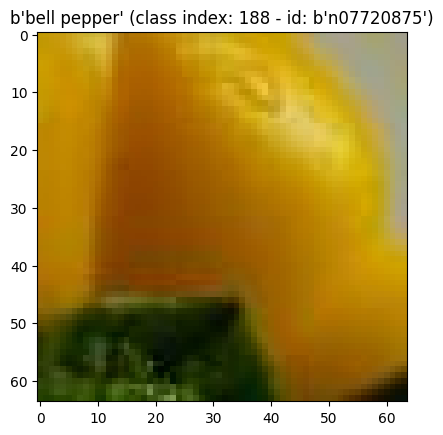

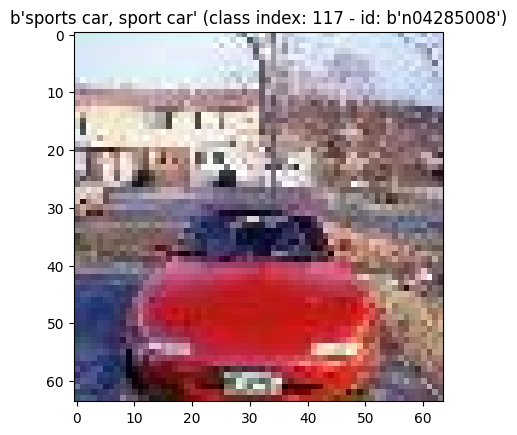

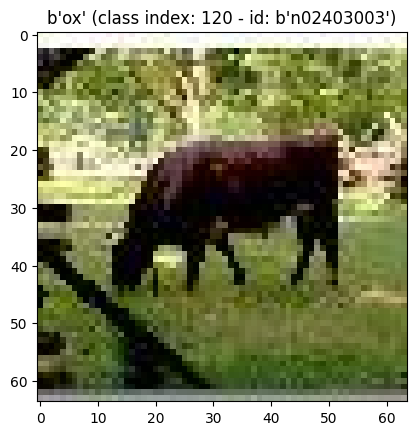

In [435]:
count = 0
images = []
for val_img in ds_val:
    img_info(val_img)
    images.append(val_img["image"])
    if count >= 2:
        break
    count += 1

In [51]:

image1 = tf.cast(tf.reshape(images[0], [1, 64, 64, 3]), tf.float32) / 255.0
image2 = tf.cast(tf.reshape(images[1], [1, 64, 64, 3]), tf.float32) / 255.0
image3 = tf.cast(tf.reshape(images[2], [1, 64, 64, 3]), tf.float32) / 255.0

quantized_image1_8b = np.round(image1 * S_8b_is[0])# + Z_8b_is[0] # comment out as it should be precomputed against weights
quantized_image2_8b = np.round(image2 * S_8b_is[0])# + Z_8b_is[0]
quantized_image3_8b = np.round(image3 * S_8b_is[0])# + Z_8b_is[0]
quantized_image1_8b.astype(np.int8).tofile("quant/images/image1_8q.bin")
quantized_image2_8b.astype(np.int8).tofile("quant/images/image2_8q.bin")
quantized_image3_8b.astype(np.int8).tofile("quant/images/image3_8q.bin")

quantized_image1_4b = np.round(image1 * S_4b_is[0])# + Z_4b_is[0]
quantized_image2_4b = np.round(image2 * S_4b_is[0])# + Z_4b_is[0]
quantized_image3_4b = np.round(image3 * S_4b_is[0])# + Z_4b_is[0]
quantized_image1_4b.astype(np.int8).tofile("quant/images/image1_4q.bin")
quantized_image2_4b.astype(np.int8).tofile("quant/images/image2_4q.bin")
quantized_image3_4b.astype(np.int8).tofile("quant/images/image3_4q.bin")

quantized_image1_2b = np.round(image1 * S_2b_is[0])# + Z_2b_is[0]
quantized_image2_2b = np.round(image2 * S_2b_is[0])# + Z_2b_is[0]
quantized_image3_2b = np.round(image3 * S_2b_is[0])# + Z_2b_is[0]
quantized_image1_2b.astype(np.int8).tofile("quant/images/image1_2q.bin")
quantized_image2_2b.astype(np.int8).tofile("quant/images/image2_2q.bin")
quantized_image3_2b.astype(np.int8).tofile("quant/images/image3_2q.bin")

NameError: name 'images' is not defined

In [ ]:
print(f"8b S_is: {S_8b_is}")
print(f"4b S_is: {S_4b_is}")
print(f"2b S_is: {S_2b_is}")

print(f"8b Z_is: {Z_8b_is}")
print(f"4b Z_is: {Z_4b_is}")
print(f"2b Z_is: {Z_2b_is}")

print(f"8b S_ws: {S_8b_ws}")
print(f"4b S_ws: {S_4b_ws}")
print(f"2b S_ws: {S_2b_ws}")

print(f"8b S_bs: {S_8b_bs}")
print(f"4b S_bs: {S_4b_bs}")
print(f"2b S_bs: {S_2b_bs}")


for i, layerlist in enumerate(Zp_macced_8b):
    for j, num in enumerate(layerlist):
        Zp_macced_8b[i][j] = round(num)

for i, layerlist in enumerate(Zp_macced_4b):
    for j, num in enumerate(layerlist):
        Zp_macced_4b[i][j] = round(num)

for i, layerlist in enumerate(Zp_macced_2b):
    for j, num in enumerate(layerlist):
        Zp_macced_2b[i][j] = round(num)

print(f"8b Zp macced: {Zp_macced_8b}")
print(f"4b Zp macced: {Zp_macced_4b}")
print(f"2b Zp macced: {Zp_macced_2b}")

8b S_is: [225.77330403  78.2820355   30.10063831  38.9806973   34.65046495
  22.17446924  14.83324517   8.22409603]
4b S_is: [12.44419786  4.31475786  1.6590903   2.14854237  1.90986815  1.22221484
  0.81758044  0.45329663]
2b S_is: [1.77774255 0.61639398 0.2370129  0.30693462 0.27283831 0.17460212
 0.11679721 0.06475666]
8b Z_is: [-98.77330566  -2.59492527  -1.56697189  -1.29760205  -2.29752769
  -2.85158814  -2.35767725  -4.66986653]
4b Z_is: [-5.44419795 -0.14302738 -0.08636853 -0.07152137 -0.12663538 -0.15717415
 -0.12995071 -0.25739422]
2b Z_is: [-0.77774256 -0.02043248 -0.01233836 -0.01021734 -0.01809077 -0.02245345
 -0.01856439 -0.0367706 ]
8b S_ws: [419.30887 260.8992  183.42577 234.51324 236.64046 248.70012 227.76791
  95.91284]
4b S_ws: [23.111511  14.380271  10.110082  12.925927  13.043175  13.707881
 12.554137   5.2865343]
2b S_ws: [3.3016446 2.0543244 1.4442974 1.846561  1.8633107 1.9582686 1.7934481
 0.7552192]
8b S_bs: [94668.7486296  20423.72047072  5521.23263884  9141.

In [11]:
given_image0 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_0.bin", dtype=np.float32)
given_image0 = tf.reshape(given_image0, [1, 64, 64, 3])
quantized_given_image0_8b = np.round(given_image0 * S_8b_is[0] + Z_8b_is[0])
quantized_given_image0_8b.astype(np.int8).tofile("quant/given_image0_8q.bin")

given_image1 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_1.bin", dtype=np.float32)
given_image1 = tf.reshape(given_image1, [1, 64, 64, 3])
quantized_given_image1_8b = np.round(given_image1 * S_8b_is[0] + Z_8b_is[0])
quantized_given_image1_8b.astype(np.int8).tofile("quant/given_image1_8q.bin")



given_image0 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_0.bin", dtype=np.float32)
given_image0 = tf.reshape(given_image0, [1, 64, 64, 3])
quantized_given_image0_4b = np.round(given_image0 * S_4b_is[0] + Z_4b_is[0])
quantized_given_image0_4b.astype(np.int8).tofile("quant/given_image0_4q.bin")

given_image1 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_1.bin", dtype=np.float32)
given_image1 = tf.reshape(given_image1, [1, 64, 64, 3])
quantized_given_image1_4b = np.round(given_image1 * S_4b_is[0] + Z_4b_is[0])
quantized_given_image1_4b.astype(np.int8).tofile("quant/given_image1_4q.bin")



given_image0 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_0.bin", dtype=np.float32)
given_image0 = tf.reshape(given_image0, [1, 64, 64, 3])
quantized_given_image0_2b = np.round(given_image0 * S_2b_is[0] + Z_2b_is[0])
quantized_given_image0_2b.astype(np.int8).tofile("quant/given_image0_2q.bin")

given_image1 = np.fromfile("/home/zfsalti/487/lab3/CprE-487-Lab-3/software/data/image_1.bin", dtype=np.float32)
given_image1 = tf.reshape(given_image1, [1, 64, 64, 3])
quantized_given_image1_2b = np.round(given_image1 * S_2b_is[0] + Z_2b_is[0])
quantized_given_image1_2b.astype(np.int8).tofile("quant/given_image1_2q.bin")




In [47]:
actual_classes = []

count = 0
for val in ds_val:
    if count >= 1000:
        break
    
    img_tensor = tf.cast(tf.reshape(val["image"], [1, 64, 64, 3]), tf.float32) / 255.0
    quant_image_8b = np.round(img_tensor * S_8b_is[0] + Z_8b_is[0])
    quant_image_8b.astype(np.int8).tofile(f"quant/images_1000_8b/{count}.bin")
    
    actual_classes.append(int(val["label"]))

    count += 1
print(actual_classes)

[58, 2, 183, 95, 173, 145, 175, 36, 87, 55, 29, 8, 187, 170, 68, 178, 39, 176, 195, 19, 32, 106, 168, 26, 80, 173, 62, 27, 145, 67, 181, 164, 77, 13, 30, 170, 116, 98, 33, 150, 76, 101, 153, 17, 42, 110, 29, 145, 67, 171, 2, 65, 121, 50, 178, 73, 96, 0, 180, 177, 127, 27, 95, 119, 14, 99, 92, 101, 2, 60, 157, 145, 74, 141, 77, 37, 195, 39, 174, 177, 103, 82, 11, 30, 183, 90, 163, 23, 160, 132, 66, 94, 186, 23, 134, 117, 140, 167, 190, 80, 170, 13, 90, 104, 100, 145, 163, 177, 130, 45, 166, 189, 81, 95, 78, 88, 154, 179, 90, 58, 173, 27, 193, 41, 32, 194, 194, 41, 150, 116, 168, 144, 178, 114, 85, 76, 111, 145, 107, 74, 114, 35, 145, 21, 77, 11, 117, 69, 168, 97, 8, 154, 52, 187, 124, 180, 21, 190, 169, 89, 167, 25, 1, 69, 83, 136, 38, 169, 38, 169, 2, 106, 176, 69, 83, 95, 35, 162, 43, 154, 54, 41, 63, 106, 198, 133, 45, 189, 143, 112, 143, 32, 174, 37, 136, 190, 64, 97, 22, 32, 4, 143, 48, 24, 187, 106, 34, 185, 86, 98, 3, 143, 24, 127, 110, 167, 167, 6, 181, 137, 162, 182, 196, 18, 7

2025-10-21 02:03:44.684260: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [49]:
actual_classes = []

count = 0
for val in ds_val:
    if count >= 1000:
        break
    
    img_tensor = tf.cast(tf.reshape(val["image"], [1, 64, 64, 3]), tf.float32) / 255.0
    quant_image_8b = np.round(img_tensor * S_4b_is[0] + Z_4b_is[0])
    quant_image_8b.astype(np.int8).tofile(f"quant/images_1000_4b/{count}.bin")
    
    actual_classes.append(int(val["label"]))

    count += 1
print(actual_classes)

2025-10-21 03:56:28.173790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[119, 116, 27, 58, 59, 188, 184, 153, 50, 2, 12, 67, 121, 96, 11, 158, 146, 190, 180, 103, 101, 30, 165, 193, 97, 4, 76, 64, 108, 125, 101, 25, 138, 95, 111, 2, 54, 4, 79, 62, 101, 153, 181, 22, 63, 44, 181, 173, 44, 53, 97, 46, 163, 153, 136, 20, 122, 117, 39, 15, 154, 192, 102, 68, 49, 17, 153, 77, 101, 149, 68, 111, 155, 191, 102, 130, 23, 45, 160, 171, 154, 61, 81, 3, 122, 127, 80, 95, 170, 90, 92, 78, 164, 49, 118, 48, 78, 193, 32, 162, 58, 33, 53, 198, 92, 97, 73, 181, 27, 62, 18, 127, 99, 39, 9, 166, 9, 30, 97, 34, 97, 26, 178, 54, 169, 106, 189, 111, 48, 25, 164, 117, 167, 22, 79, 75, 174, 5, 116, 138, 98, 140, 101, 28, 59, 134, 19, 99, 191, 79, 115, 60, 105, 18, 6, 154, 8, 157, 169, 39, 183, 185, 134, 181, 107, 37, 23, 124, 138, 17, 108, 0, 196, 69, 6, 142, 45, 161, 51, 154, 150, 150, 130, 120, 147, 51, 64, 16, 140, 136, 189, 172, 42, 143, 94, 32, 83, 3, 183, 100, 170, 163, 92, 1, 143, 80, 106, 147, 168, 128, 95, 127, 46, 162, 144, 106, 187, 145, 172, 144, 56, 131, 10, 114, 19